***  klampt.vis: using Qt5 as the visualization backend  ***


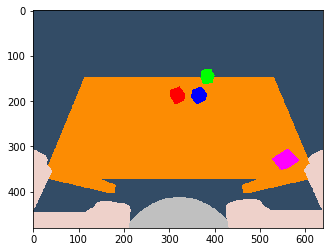

In [56]:
from klampt import WorldModel,Geometry3D
from klampt.model import sensing, ik
import time
import matplotlib.pyplot as plt
import klampt
from klampt import vis
from klampt.math import so3,se3, vectorops
import trimesh
import os
import random
import numpy as np
import math
from math import radians
from IPython.display import clear_output
import ipywidgets as widgets
from klampt.vis.ipython import KlamptWidget
%matplotlib inline

model_path = "../Resources/shared_data/objects/"
mesh_model_path = "../Resources/grasping/models/"

class testingWorldBuilder():
    def __init__(self,floor_length = 20, floor_width = 20):
        self.w = WorldModel()
        self.floor =  Geometry3D()
        self.floor.loadFile(model_path+"cube.off")
        self.floor.transform([floor_length,0,0,0,floor_width,0,0,0,0.01],[-floor_length/2.0,-floor_width/2.0,-0.01])
        floor_terrain = self.w.makeTerrain("floor")
        floor_terrain.geometry().set(self.floor)
        floor_terrain.appearance().setColor(0.4,0.3,0.2,1.0)

        ###colors
        self.light_blue = [3.0/255.0, 140.0/255.0, 252.0/255.0,1.0]
        self.wall_green = [50.0/255.0, 168.0/255.0, 143.0/255.0,1.0]
        ###sizes
        self.table_length = 1.0
        self.table_width = 0.5
        self.table_top_thickness = 0.03
        self.table_height = 0.6
        self.leg_width = 0.05
        self.cube_width = 0.05

    def getWorld(self):
        return self.w

    def addTableTopScenario(self,x=0,y=0):
        """
        add a table with objects on top, the center of table can be set
        Parameters:
        --------------
        x,y: floats, the position of the table center
        """

        self.addTable(x,y)
        
        # add some cubes
        self.addCube((so3.from_axis_angle(([0,0,1],0.5)), [x /2, y / 2, self.table_height]), self.cube_width, [1.0, 0, 0, 1], 1)
        self.addCube((so3.from_axis_angle(([0,0,1],5)), [x / 2 + .1, y / 2, self.table_height]), self.cube_width, [0, 1.0, 0, 1], 2)
        self.addCube((so3.from_axis_angle(([0,0,1],0.5)), [x / 2, y / 2 + .1, self.table_height]), self.cube_width, [0, 0, 1.0, 1], 3)
        self.addCube((so3.from_axis_angle(([0,0,1],0.5)), [x / 2 - .3, y / 2 - .3, self.table_height]), self.cube_width, [1.0, 0, 1.0, 1], 3)
        
        '''
        # add one mesh
        self.addRandomMesh([0+x,0.2+y,self.table_height],1)
        self.addRandomMesh([0+x,-0.2+y,self.table_height],2)
        self.addRandomMesh([0.2+x,0+y,self.table_height],3)
        self.addRandomMesh([-0.2+x,-0.2+y,self.table_height],4)
        '''

    ##Functions below add individual objects
    def addCube(self,T,side_length,color,ID,object_mass = 0.1):
        """
        Add a cube to the world.
        Parameters:
        --------------
        T:world transform of the cube
        side_length: float, size of the cube
        color: RGBA values, (0-1)
        ID: int, cannot duplicate
        mass:object mass added at the object geometric center
        """

        self._addRigidObject(model_path + "cube.off",([side_length,0,0,0,side_length,0,0,0,side_length,],[0,0,0]),T,\
            color,object_mass,[side_length/2.0,side_length/2.0,side_length/2.0],"cube"+str(ID))

    def addMesh(self,path,T,color,mass,ID):
        """
        Add a mesh to the world.
        Parameters:
        --------------
        path: path to the mesh file
        T:world transform of the mesh
        color: RGBA values, (0-1)
        mass:object mass added at the object geometric center
        ID: int, cannot duplicate
        """
        mesh = trimesh.load(path)
        mesh_center = mesh.centroid.tolist()

        # load the rigid object in the world
        self._addRigidObject(path,([1,0,0,0,1,0,0,0,1],[0]*3),T,\
            color,mass,mesh_center,"item"+str(ID))

    def addRandomMesh(self,t,ID = 1):
        """
        Add a household item to the world, randonmly selected from the library.
        Color is also determined randomly. Mass set to 1kg arbitrarily
        Parameters:
        --------------
        t:world position of the mesh
        ID: int, cannot duplicate
        """
        meshpaths = []
        for file in os.listdir(mesh_model_path):
            if file.endswith(".ply"):
                meshpaths.append(os.path.join(mesh_model_path, file))

        meshpath = random.choice(meshpaths)
        mesh = trimesh.load(meshpath)
        mesh_center = mesh.centroid.tolist()
        #Z_min = np.min(mesh.vertices[:,2])

        #t[2] = t[2]+mesh_center[2]-Z_min
        # load the rigid object in the world
        self._addRigidObject(meshpath,([1,0,0,0,1,0,0,0,1],[0]*3),([1,0,0,0,1,0,0,0,1],t),\
            (random.random(),random.random(),random.random(),1.0),0.1,mesh_center,"item"+str(ID))

    def addTable(self,x=0,y=0):
        """
        Add a table to the world
        Parameters:
        --------------
        x,y: floats, the x,y position of the center of the table
        """
        table_top = Geometry3D()
        table_leg_1 = Geometry3D()
        table_leg_2 = Geometry3D()
        table_leg_3 = Geometry3D()
        table_leg_4 = Geometry3D()

        table_top.loadFile(model_path + "cube.off")
        table_leg_1.loadFile(model_path + "cube.off")
        table_leg_2.loadFile(model_path + "cube.off")
        table_leg_3.loadFile(model_path + "cube.off")
        table_leg_4.loadFile(model_path + "cube.off")

        table_top.transform([self.table_length,0,0,0,self.table_width,0,0,0,\
            self.table_top_thickness],[0,0,self.table_height - self.table_top_thickness])
        table_leg_1.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height\
            - self.table_top_thickness],[0,0,0])
        table_leg_2.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - \
            self.table_top_thickness],[self.table_length-self.leg_width,0,0])
        table_leg_3.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[self.table_length-self.leg_width,self.table_width-self.leg_width,0])
        table_leg_4.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[0,self.table_width-self.leg_width,0])

        table_geom = Geometry3D()
        table_geom.setGroup()
        for i,elem in enumerate([table_top,table_leg_1,table_leg_2,table_leg_3,table_leg_4]):
            g = Geometry3D(elem)
            table_geom.setElement(i,g)
        #table_geom.transform([1,0,0,0,1,0,0,0,1],[x-self.table_length/2.0,y-self.table_width/2.0,0])
        table_geom.transform(so3.from_rpy([0, 0, math.pi/2]),[x-self.table_length/2.0,y-self.table_width/2.0,0])
        table = self.w.makeTerrain("table")
        table.geometry().set(table_geom)
        table.appearance().setColor(self.light_blue[0],self.light_blue[1],self.light_blue[2],self.light_blue[3])

    def addRobot(self,path,T):
        """
        Add a robot to the world. You can directly use Klampt functions to add to the world as well
        Parameters:
        ------------
        path: path to the robot model
        T: transform of the base of the robot
        """

        self.w.loadRobot(path)
        rob = self.w.robot(0)
        #rob.link(3).setTransform(T[0], T[1])

    def _addRigidObject(self,path,T_g,T_p,color,object_mass,Com,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T_g[0],T_g[1])
        item_1 = self.w.makeRigidObject(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        bmass = item_1.getMass()
        bmass.setMass(object_mass)
        bmass.setCom(Com)
        item_1.setMass(bmass)
        item_1.setTransform(T_p[0],T_p[1])
        return item_1

    def _addTerrain(self,path,T,color,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T[0],T[1])
        item_1 = self.w.makeTerrain(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        return item_1

def reset_arms(robot):
    leftResetConfig = [0.7934, -2.5412, -2.7833, 4.6648, -0.0491, 0.0973]
    rightResetConfig = [-0.7934, -0.6003, 2.7833, -1.5232, 0.0491, -0.0973]
    config = [0]*7 + leftResetConfig + [0, 0] + rightResetConfig + [0]
    robot.setConfig(config)

def ik_solve(target_position, first_time = False):
    left_ee_link = robot.link(13)
    left_active_dofs = [7, 8, 9, 10, 11, 12]

    ee_local_pos = [0, 0, 0]
    h = 0.1
    local = [ee_local_pos, vectorops.madd(ee_local_pos, (1, 0, 0), -h)]
    world = [target_position, vectorops.madd(target_position, (0, 0, 1), h)]
    goal = ik.objective(left_ee_link, local=local, world=world)

    if first_time:
        solved = ik.solve_global(goal, activeDofs = left_active_dofs, startRandom=True)
    else:
        solved = ik.solve(goal, activeDofs = left_active_dofs)

    if solved:
        print("solve success")
        return True
    else:
        print("Solve unsuccessful")
        return False


def transform_to_string(R, t):
    rv = " ".join(map(str, R)) + " ".join(map(str, t))
    return rv

# add table + robot
builder = testingWorldBuilder(30,30)
builder.addTableTopScenario(x=1.3,y=-0.25)
builder.addRobot("../Motion/data/robots/Anthrax.urdf", None)

w = builder.getWorld()
robot = w.robot(0)
reset_arms(robot)
sim = klampt.Simulator(w)

# setup simulated camera
cam = klampt.SimRobotSensor(sim.controller(0), "rgbd_camera", "CameraSensor")
# mount camera in place
cam.setSetting("link","4")

#cam.setSetting("Tsensor","0.0 -0.866 -0.5 1.0 0.0 0.0  0 -0.5 0.866      0.2 0.005 1.2")
cam.setSetting("Tsensor", transform_to_string(so3.from_rpy((math.pi, radians(-30), radians(270))), [0.2, 0.005, 1.2]))
# minimum range
cam.setSetting("zmin","0.1")
# x field of view
cam.setSetting("xfov","1.5")

# Take a picture!
cam.kinematicSimulate(w, 0.01)
rgb, depth = sensing.camera_to_images(cam)
plt.imshow(rgb)
plt.show()
time.sleep(0.5)

positions = [(0.5, 0.5), (0.5, 0.4), (0.5, 0.3), (0.5, 0.2), (0.5, 0.1), (0.5, 0.0), (0.5, -0.1)]
first_time = True

# run the simulation (indefinitely)
# for e in positions:
#     rv = ik_solve([e[0], e[1], 0.65], first_time)
#     rgb, depth = sensing.camera_to_images(cam)
#     plt.imshow(rgb)
#     plt.show()
#     time.sleep(1.0)
#     first_time = not first_time

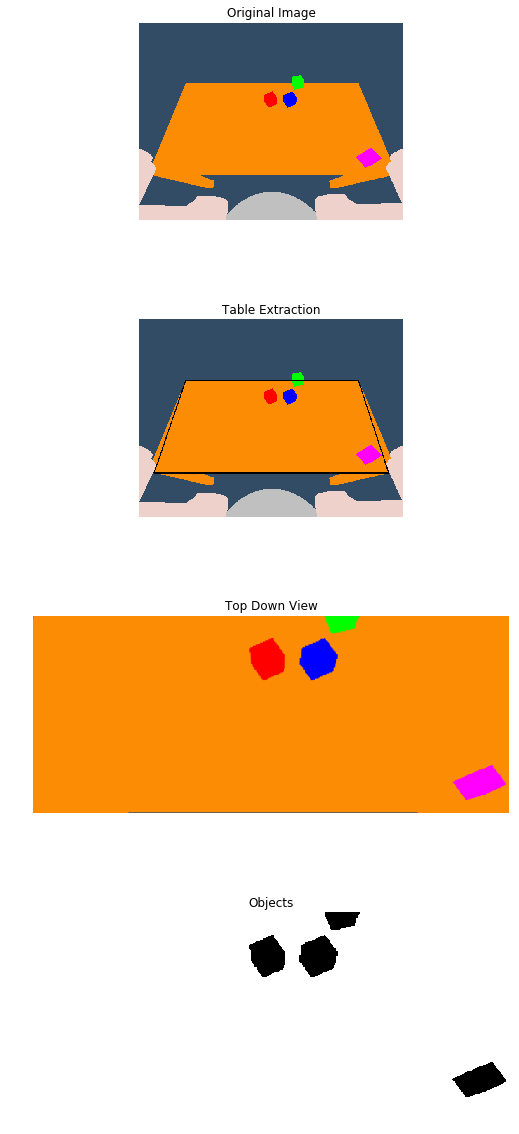

In [974]:
import numpy as np
import cv2

def extract_table(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    lower = np.array([10, 0, 0])
    upper = np.array([40, 255, 255])
    mask = cv2.inRange(img_hsv, lower, upper)
    return mask
    
def get_approx(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    eps = .01 * cv2.arcLength(contours[0], True)
    approx = cv2.approxPolyDP(contours[0], eps, True)
    
    return approx

def get_table_coords(approx):
    top_y = min([pt[0][1] for pt in approx])
    eps = 10 # Arbitrary closeness value

    top_x_coords = [pt[0][0] for pt in approx if abs(top_y - pt[0][1]) < eps] # X of points on top edge of table
    top_x_coords = sorted(top_x_coords)

    tl = (top_x_coords[0], top_y)
    tr = (top_x_coords[-1], top_y)

    outer = [pt[0] for pt in approx if pt[0][0] < tl[0] or pt[0][0] > tr[0]] # List of points on outside of table

    bottom_y = max([pt[1] for pt in outer])
    bottom_x_coords = [pt[0] for pt in outer if abs(bottom_y - pt[1]) < eps]
    bottom_x_coords = sorted(bottom_x_coords)

    bl = (bottom_x_coords[0], bottom_y)
    br = (bottom_x_coords[-1], bottom_y)
    
    return (tl, tr, bl, br)

# Modified from https://stackoverflow.com/a/47830321
def unwarp(img, src, dest):
    w, h = dest[3]
    
    M = cv2.getPerspectiveTransform(src, dest) # Get transform matrix
    top_down = cv2.warpPerspective(img, M, (w, h)) # Warp to top down view
    return top_down

# Modified from https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def get_dest_coords(corners, img):
    tl, tr, bl, br = corners

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dest = np.array(
        [
            [0, 0],
            [maxWidth - 1, 0],
            [0, maxHeight - 1],
            [maxWidth - 1, maxHeight - 1]
        ], dtype = "float32")
    
    return dest

#bgr = cv2.imread('img.png')
#rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) # CV uses BGR by default, pyplot uses RGB
mask = extract_table(rgb)
approx = get_approx(mask)
corners = get_table_coords(approx)

table_contours = rgb.copy()
contour_points = (corners[0], corners[1], corners[3], corners[2])
cv2.drawContours(table_contours, np.array([[contour_points]]), -1, (1, 0, 0), 2)

src = np.float32(corners)
dest = get_dest_coords(corners, rgb)
top_down = unwarp(rgb, src, dest)
object_mask = extract_table(top_down)


f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (30, 20))
f.subplots_adjust(hspace = .5)

ax1.imshow(rgb)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(table_contours)
ax2.set_title("Table Extraction")
ax2.axis("off")

ax3.imshow(top_down)
ax3.set_title("Top Down View")
ax3.axis("off")

ax4.imshow(object_mask, cmap = "gray")
ax4.set_title("Objects")
ax4.axis("off")

plt.show()